In [11]:
install.packages(c('purrr'))

Installing package into ‘/home/rol046/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



In [12]:
# install.packages(c('jsonlite', 'dplyr', 'ggplot2', 'forcats'))
library(jsonlite)
library(dplyr)
library(ggplot2)
library(forcats)
library(purrr)


In [24]:
# === CONFIG ===
ordination_file <- "ordination.json"
contextual_file <- "contextual.json"

# === PARAMETERS ===
dissimilarity_method <- "braycurtis"  # Only "braycurtis" supported at the moment
contextual_variable <- "ph"

# === LOAD DATA ===
ordination_data <- fromJSON(ordination_file)
contextual_data <- fromJSON(contextual_file)

# Convert samples to data.frame
contextual <- as.data.frame(do.call(rbind, contextual_data$samples))
contextual$sample_id <- rownames(contextual)

# Create a named list of definitions
definitions <- contextual_data$definitions

# === PREP ORDINATIONS AND MERGE CONTEXTUAL DATA ===
ordination <- as.data.frame(ordination_data$points[[dissimilarity_method]])
colnames(ordination) <- c("UMAP1", "UMAP2")
ordination$sample_id <- ordination_data$sample_ids

merged <- ordination %>%
  left_join(contextual, by = "sample_id")



In [26]:
# === DETERMINE VARIABLE TYPE & MAP IF ONTOLOGY ===
if (!(contextual_variable %in% colnames(merged))) {
  stop(paste("Variable", contextual_variable, "not found in contextual data."))
}

definition <- definitions %>% filter(name == contextual_variable)
colour_data <- merged[[contextual_variable]]

print(definition)

if (!is.null(definition) && definition$type == "ontology") {
  colour_label <- paste0(contextual_variable, "_label")

  # Map ontology values, replace empty string with "N/A"
  value_matrix <- definition$values[[1]]

  # flatten column
  merged[[contextual_variable]] <- sapply(merged[[contextual_variable]], function(x) if(length(x) == 0) NA else x[1])
  mapped_values <- sapply(merged[[contextual_variable]], function(id) {
    idx <- which(value_matrix[,1] == as.character(id))
    if(length(idx) == 0 || value_matrix[idx,2] == "") "N/A" else value_matrix[idx,2]
  })
 
  # convert to factor
  categories <- c(value_matrix[,2], "N/A") %>% unique()
  mapped_values <- factor(mapped_values, levels = categories, ordered = TRUE)
  merged[[colour_label]] <- mapped_values
  
  is_continuous <- FALSE
} else {
  colour_label <- contextual_variable
  is_continuous <- TRUE #(merged[[colour_label]])
}

  values  type name environment display_name units
1   NULL float   ph          NA           pH  <NA>
                                                                       definition
1 Soil pH using CaCl method or pH of a water sample (includes sediment porewater)


[1] TRUE

Warning message:
“Removed 76 rows containing missing values or values outside the scale range (`geom_point()`).”


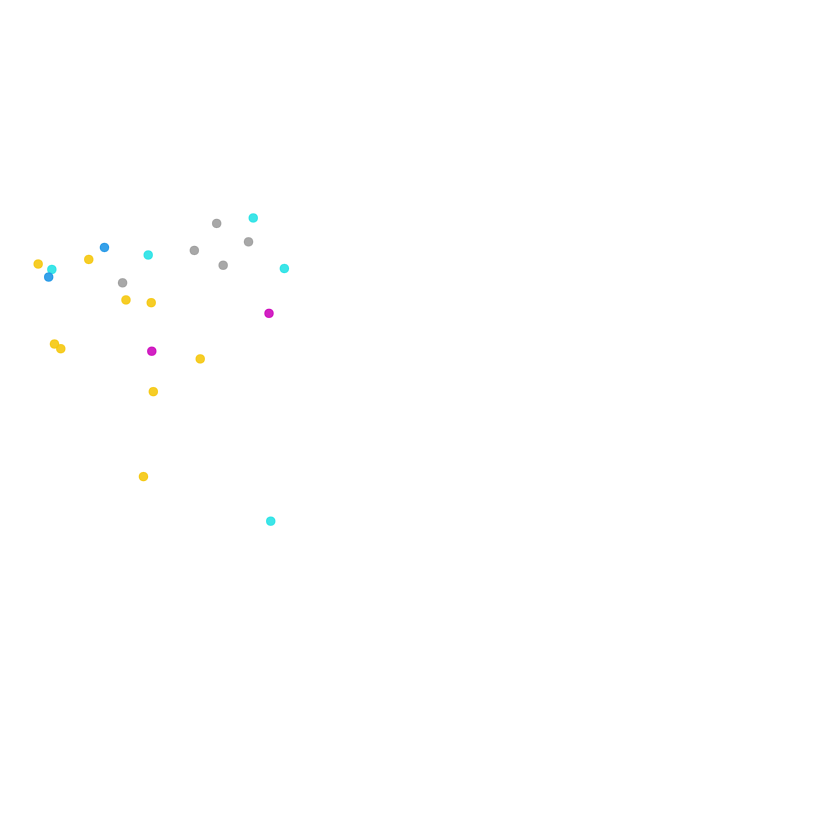

In [27]:
is_continuous

p <- ggplot(merged, aes(x = UMAP1, y = UMAP2)) +
  theme_void() +
  geom_point(aes(color = !!ensym(colour_label)), size = 2, alpha = 0.9)

p

In [28]:
# === PLOT ===
p <- ggplot(merged, aes(x = UMAP1, y = UMAP2)) + theme_void()

print(is_continuous)

if (is_continuous) {
    print(definition)
  p <- p +
    geom_point(aes(color = !!ensym(colour_label)), size = 2, alpha = 0.9) +
    scale_color_viridis_c(name = if (!is.null(definition)) definition$display_name else contextual_variable)
} else {
  p <- p +
    geom_point(aes(color = !!ensym(colour_label)), size = 2, alpha = 0.9) +
    scale_color_manual(
      values = scales::hue_pal()(length(levels(merged[[colour_label]]))),
      name = if (!is.null(definition)) definition$display_name else contextual_variable
    )
}

title_text <- paste("Ordination Coloured by", if (!is.null(definition)) definition$display_name else contextual_variable)
p <- p + ggtitle(title_text)

print(p)

# Print definition if available
if (!is.null(definition) && "definition" %in% names(definition)) {
  cat("\nDefinition for '", contextual_variable, "':\n", definition$definition, "\n", sep = "")
}

[1] TRUE
  values  type name environment display_name units
1   NULL float   ph          NA           pH  <NA>
                                                                       definition
1 Soil pH using CaCl method or pH of a water sample (includes sediment porewater)


ERROR: Error in is.finite(x): default method not implemented for type 'list'
